In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import emoji
from sklearn.model_selection import train_test_split, GridSearchCV
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import confusion_matrix
from sklearn import preprocessing
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier

import warnings
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings(action='ignore', category=DataConversionWarning)
warnings.filterwarnings(action='ignore', category=FutureWarning)
pd.set_option('display.max_columns', None)

In [12]:
#Loading the dataset
df=pd.read_csv("D:\Excel sheets\feb-20-flight-delay.csv")

### Data Format

**MONTH** - Month

**DAY_OF_MONTH** - Day of Month

**DAY_OF_WEEK** - Day of Week

**OP_UNIQUE_CARRIER** - Unique Carrier Code

**ORIGIN** - Origin airport location

**DEST** - Destination airport location

**DEP_TIME** - Actual Departure Time (local time: hhmm)

**DEP_DEL15** - Departure Delay Indicator, 15 Minutes or More (1=Yes, 0=No) [TARGET VARIABLE]

**DISTANCE** - Distance between airports (miles)

In [26]:
df.head()

,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,OP_UNIQUE_CARRIER,ORIGIN,DEST,DEP_TIME,DEP_DEL15,DISTANCE,Unnamed: 9
0,2,1,6,MQ,CLT,LYH,1430.0,0.0,175.0,NaN
1,2,8,6,MQ,CLT,LYH,1442.0,0.0,175.0,NaN
2,2,13,4,MQ,DFW,SHV,2247.0,0.0,190.0,NaN
3,2,14,5,MQ,DFW,SHV,2230.0,0.0,190.0,NaN
4,2,15,6,MQ,DFW,SHV,2246.0,0.0,190.0,NaN


## Data Preprocessing

We might have an extra column in our dataset, let's get rid of it first

In [28]:
df= df.drop(['Unnamed: 9'], axis=1)

In [29]:
df['DEP_DEL15'].value_counts()

0.0    487135
1.0     82182
Name: DEP_DEL15, dtype: int64

We can see that we have highly imbalanced data, as we there are only 14.43% rows with the value of 1.0 (Delay in flight).

In [32]:
# Split the data into positive and negative
positive_rows = df.DEP_DEL15 == 1.0
data_pos = df.loc[positive_rows]
data_neg = df.loc[~positive_rows]

# Merge the balanced data
df = pd.concat([data_pos, data_neg.sample(n = len(data_pos))], axis = 0)

# Shuffle the order of data
df = df.sample(n = len(df)).reset_index(drop = True)

let's quickly remove the NULL values if present any

In [33]:
df.isna().sum()

MONTH                  0
DAY_OF_MONTH           0
DAY_OF_WEEK            0
OP_UNIQUE_CARRIER      0
ORIGIN                 0
DEST                   0
DEP_TIME             838
DEP_DEL15            839
DISTANCE               0
dtype: int64

There are around **~0.5% NULL** values present in **DEP_TIME** and **DEP_DEL15**

In [34]:
df.shape

(164364, 9)

In [35]:
df.columns

Index(['MONTH', 'DAY_OF_MONTH', 'DAY_OF_WEEK', 'OP_UNIQUE_CARRIER', 'ORIGIN',
       'DEST', 'DEP_TIME', 'DEP_DEL15', 'DISTANCE'],
      dtype='object')

In [37]:
df = df.dropna(axis=0)

In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 163525 entries, 0 to 164363
Data columns (total 9 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   MONTH              163525 non-null  int64  
 1   DAY_OF_MONTH       163525 non-null  int64  
 2   DAY_OF_WEEK        163525 non-null  int64  
 3   OP_UNIQUE_CARRIER  163525 non-null  object 
 4   ORIGIN             163525 non-null  object 
 5   DEST               163525 non-null  object 
 6   DEP_TIME           163525 non-null  float64
 7   DEP_DEL15          163525 non-null  float64
 8   DISTANCE           163525 non-null  float64
dtypes: float64(3), int64(3), object(3)
memory usage: 12.5+ MB


We see that our target variable **DEP_DEL15** has the datatype of *float64.*

Let's convert it into *int.*

In [41]:
df['DEP_DEL15'] = df['DEP_DEL15'].astype(int)

Now let's have a look at the number of columns and rows in our dataset.

In [42]:
print(f"There are {df.shape[0]} rows and {df.shape[1]} columns in our dataset.")

There are 163525 rows and 9 columns in our dataset.


# Exploratory Data Analysis

Let's uncover some meaningful and hidden insights out of our dataset.

In [43]:
df.describe()

,MONTH,DAY_OF_MONTH,DAY_OF_WEEK,DEP_TIME,DEP_DEL15,DISTANCE
count,163525.0,163525.000000,163525.000000,163525.000000,163525.000000,163525.000000
mean,2.0,14.819135,4.019703,1416.429433,0.502565,791.042073
std,0.0,8.171048,1.918811,498.737348,0.499995,572.903454
min,2.0,1.000000,1.000000,1.000000,0.000000,31.000000
25%,2.0,7.000000,2.000000,1026.000000,0.000000,370.000000
50%,2.0,14.000000,4.000000,1437.000000,1.000000,644.000000
75%,2.0,22.000000,6.000000,1827.000000,1.000000,1034.000000
max,2.0,29.000000,7.000000,2400.000000,1.000000,5095.000000


Apart from the statistics given in the table above, we can also that there are 6 numerical and 3 categorical variables in our dataset.

Let's quickly visualize the distribution of **DISTANCE** variable

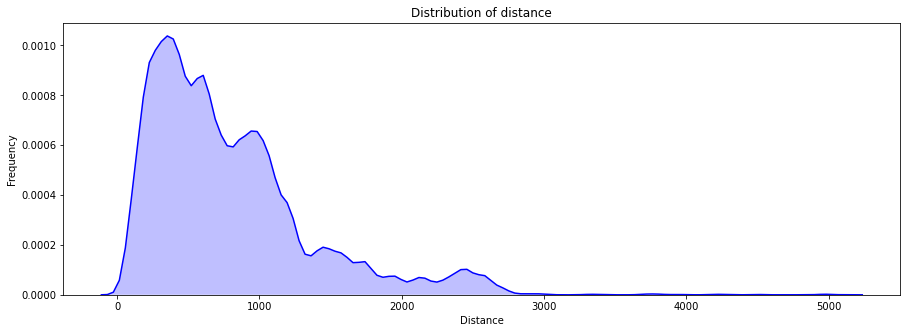

In [44]:
plt.figure(figsize=(15,5))
sns.distplot(df['DISTANCE'], hist=False, color="b", kde_kws={"shade": True})
plt.xlabel("Distance")
plt.ylabel("Frequency")
plt.title("Distribution of distance")
plt.show()

We can see that our **DISTANCE** variable is positively skewed. I am just curious to find out the correlation between the distance and delay of a flight.

In [45]:
print(emoji.emojize("Let's find it out :fire:"))

Let's find it out 🔥


Though, there is no possible way to find correlation between a continuous and categorical variable, I'll try to find the average distance for **DEP_DEL15** variable.

In [46]:
print(f"Average distance if there is a delay {df[df['DEP_DEL15'] == 1]['DISTANCE'].values.mean()} miles")
print(f"Average distance if there is no delay {df[df['DEP_DEL15'] == 0]['DISTANCE'].values.mean()} miles")

Average distance if there is a delay 786.1071280815751 miles
Average distance if there is no delay 796.027918812928 miles


Let's visualize the categorical variables.

### Count of carriers in the dataset

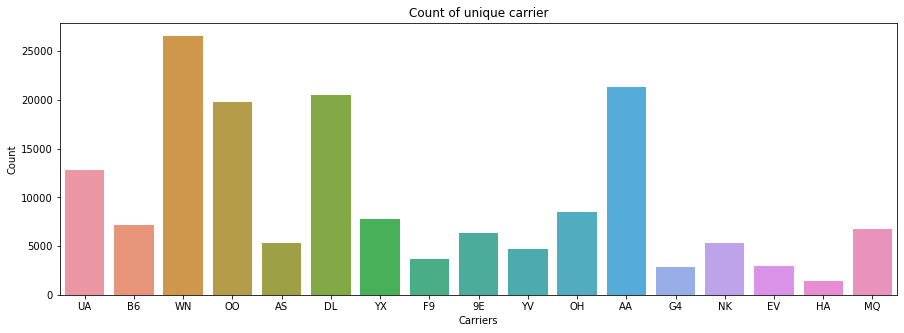

In [47]:
plt.figure(figsize=(15,5))
sns.countplot(x=df['OP_UNIQUE_CARRIER'], data=df)
plt.xlabel("Carriers")
plt.ylabel("Count")
plt.title("Count of unique carrier")
plt.show()


### Count of origin and destination airport

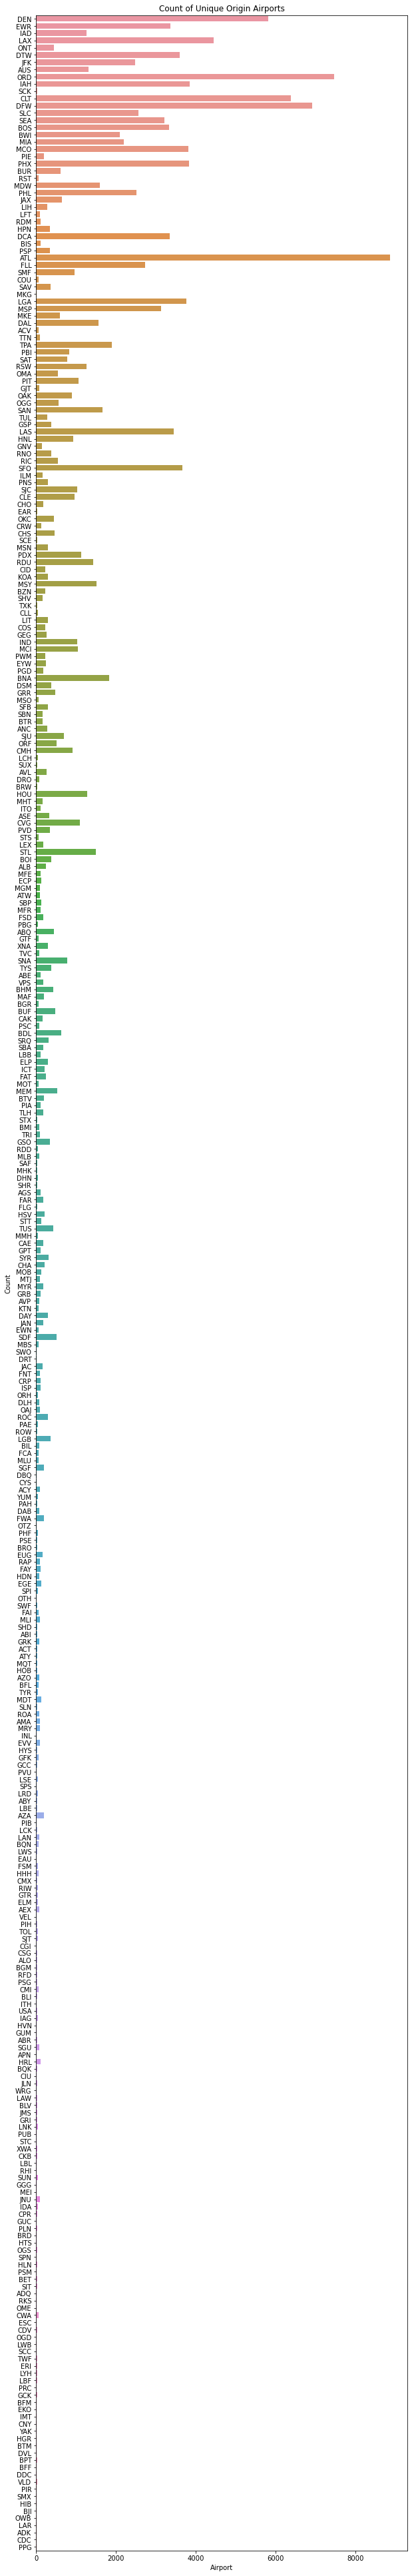

In [48]:
plt.figure(figsize=(10,70))
sns.countplot(y=df['ORIGIN'], data=df, orient="h")
plt.xlabel("Airport")
plt.ylabel("Count")
plt.title("Count of Unique Origin Airports")
plt.show()

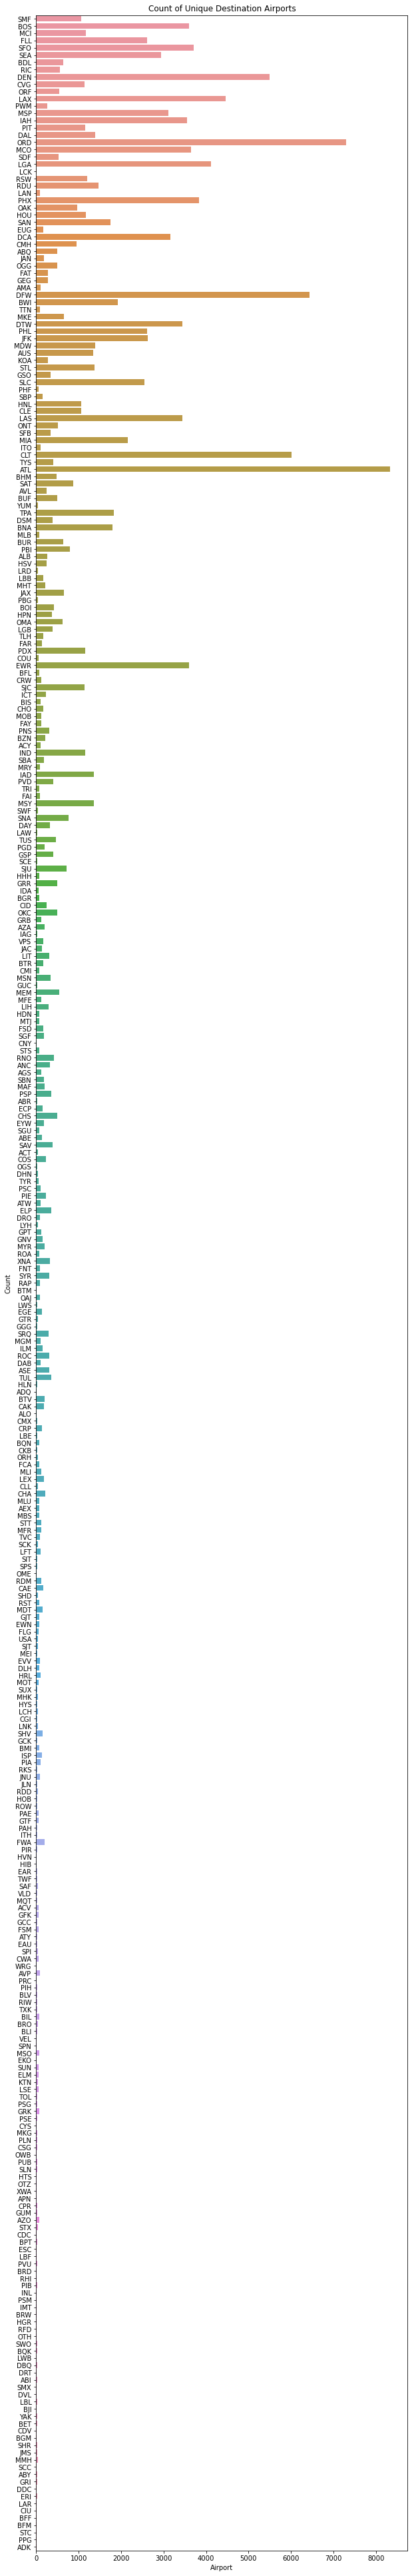

In [49]:
plt.figure(figsize=(10,70))
sns.countplot(y=df['DEST'], data=df, orient="h")
plt.xlabel("Airport")
plt.ylabel("Count")
plt.title("Count of Unique Destination Airports")
plt.show()

## Modelling

Our **MONTH** variable is constant so it will not have any effect on in the training. It's better to remove it. Also, let's rename the **DEP_DEL15** column name to **TARGET** to avoid confusion between predictors and target variable.

In [50]:
df.drop('MONTH',axis=1,inplace=True)

In [51]:
df = df.rename(columns={'DEP_DEL15':'TARGET'})

In [52]:
df.head()

,DAY_OF_MONTH,DAY_OF_WEEK,OP_UNIQUE_CARRIER,ORIGIN,DEST,DEP_TIME,TARGET,DISTANCE
0,11,2,UA,DEN,SMF,1955.0,1,909.0
1,11,2,B6,EWR,BOS,1705.0,1,200.0
2,17,1,WN,DEN,MCI,1928.0,1,533.0
3,7,5,UA,IAD,FLL,853.0,1,901.0
4,2,7,OO,LAX,SFO,2222.0,1,337.0


### Encoding the categorical variable

In [53]:
def label_encoding(categories):
    """
    To perform mapping of categorical features
    """
    categories = list(set(list(categories.values)))
    mapping = {}
    for idx in range(len(categories)):
        mapping[categories[idx]] = idx
    return mapping

In [54]:
df['OP_UNIQUE_CARRIER'] = df['OP_UNIQUE_CARRIER'].map(label_encoding(df['OP_UNIQUE_CARRIER']))

In [55]:
df['ORIGIN'] = df['ORIGIN'].map(label_encoding(df['ORIGIN']))

In [56]:
df['DEST'] = df['DEST'].map(label_encoding(df['DEST']))

In [57]:
df.head()

,DAY_OF_MONTH,DAY_OF_WEEK,OP_UNIQUE_CARRIER,ORIGIN,DEST,DEP_TIME,TARGET,DISTANCE
0,11,2,12,78,61,1955.0,1,909.0
1,11,2,0,312,336,1705.0,1,200.0
2,17,1,6,78,28,1928.0,1,533.0
3,7,5,12,279,23,853.0,1,901.0
4,2,7,8,110,183,2222.0,1,337.0


In [58]:
df['TARGET'].value_counts()

1    82182
0    81343
Name: TARGET, dtype: int64

In [59]:
X = df[['DAY_OF_MONTH', 'DAY_OF_WEEK', 'OP_UNIQUE_CARRIER', 'ORIGIN', 'DEST', 'DEP_TIME', 'DISTANCE']].values
y = df[['TARGET']].values

In [60]:
# Splitting Train-set and Test-set
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.2, random_state=41)

# Splitting Train-set and Validation-set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=41)

## Choosing the evaluation metric

Here we will go with the **Accuracy** metric for our predicted values because we have already balanced our dataset. So, accuracy is the best metric to evaluate any binary classification problem if it is performed on a balanced dataset.

In [61]:
# Formula to get accuracy
def get_accuracy(y_true, y_preds):
    # Getting score of confusion matrix
    true_negative, false_positive, false_negative, true_positive = confusion_matrix(y_true, y_preds).ravel()
    # Calculating accuracy
    accuracy = (true_positive + true_negative)/(true_negative + false_positive + false_negative + true_positive)
    return accuracy

### Creating some baseline models

#### Logistic Regression

In [62]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(random_state=0).fit(X_train, y_train)

C:\Users\HP\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


#### CatboostClassifier

In [63]:
# Initialize CatBoostClassifier
catboost = CatBoostClassifier(random_state=0)
catboost.fit(X_train, y_train, verbose=False)

#### Naive Bayes

In [64]:
gnb = GaussianNB()
gnb.fit(X_train, y_train)

GaussianNB(priors=None, var_smoothing=1e-09)

#### Random Forest Classifier

In [65]:
rf = RandomForestClassifier(random_state=0)
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

#### KNN Classifier

In [66]:
knn = KNeighborsClassifier(n_neighbors=2)
knn.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=2, p=2,
                     weights='uniform')

#### XGBoost Classifier

In [67]:
xgb = XGBClassifier()
xgb.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.300000012, max_delta_step=0, max_depth=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=0, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)

### Evaluation of accuracy on validation dataset


In [68]:
models = [lr, catboost, gnb, rf, knn, xgb]
acc = []
for model in models:
    preds_val = model.predict(X_val)
    accuracy = get_accuracy(y_val, preds_val)
    acc.append(accuracy)

In [69]:
model_name = ['Logistic Regression', 'Catboost', 'Naive Bayes', 'Random Forest', 'KNN', 'XGBoost']
accuracy = dict(zip(model_name, acc))

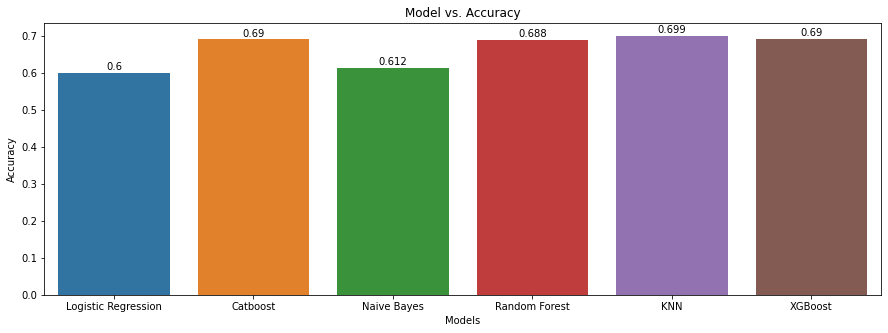

In [70]:
plt.figure(figsize=(15,5))
ax = sns.barplot(x = list(accuracy.keys()), y = list(accuracy.values()))
for p, value in zip(ax.patches, list(accuracy.values())):
    _x = p.get_x() + p.get_width() / 2
    _y = p.get_y() + p.get_height() + 0.008
    ax.text(_x, _y, round(value, 3), ha="center") 
plt.xlabel("Models")
plt.ylabel("Accuracy")
plt.title("Model vs. Accuracy")
plt.show()

We tried to fit our data on default parameters of different algorithms for binary classification.

Surprisingly, **KNN Classifier** turned out to best in terms of validation set accuracy.

Now we'll try to find the best possible parameters for K-Nearest Neighbors Algorithm.

### Accuracy on Test set with KNN before hyperparameter tuning

In [71]:
test_preds = knn.predict(X_test)
get_accuracy(y_test, test_preds)

0.7000152881822351

### Hyperparameter tuning for KNN

In [72]:
leaf_size = list(range(1,5))
n_neighbors = list(range(1,3))
p=[1,2]

hyperparameters = dict(leaf_size=leaf_size, n_neighbors=n_neighbors, p=p)

knn_2 = KNeighborsClassifier()

clf = GridSearchCV(knn_2, hyperparameters, cv=2)

best_model = clf.fit(X_train,y_train)

print('Best leaf_size:', best_model.best_estimator_.get_params()['leaf_size'])
print('Best p:', best_model.best_estimator_.get_params()['p'])
print('Best n_neighbors:', best_model.best_estimator_.get_params()['n_neighbors'])

Best leaf_size: 2
Best p: 1
Best n_neighbors: 1


In [73]:
knn_best = KNeighborsClassifier(leaf_size=3, p=1, n_neighbors=1)

In [74]:
knn_best.fit(X_train, y_train)
test_preds_1 = knn_best.predict(X_test)

### Accuracy on Test set with KNN after hyperparameter tuning

In [75]:
get_accuracy(y_test, test_preds_1)

0.7615655098608776

## Conclusion

**We see an increment of ~ 6.1% in the accuracy of our model after tuning the hyperparamter.**

**Accuracy can be improved further if time and resources are given**